In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute        import SimpleImputer

from typing import Tuple, List, Set, Dict, Iterable, Callable, Optional, Union

In [2]:
from modules.base    import CustomTransformer
from modules.compose import GroupByTransformer
from modules.impute  import InterpolationImputer
#from modules.outliers      import RangeOutlierDetector, DeltaFromMedianOutlierDetector
from modules.preprocessing import MultilabelEncoder, RegexTransformer

<div class="alert alert-info">
  <h1><center>Data (2 балла)</center></h1></div>

In [3]:
df = pd.read_csv("data/train.csv", low_memory=False)
df.columns = map(str.lower, df.columns)
df.head(2)

,id,year,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,...,income,credit_type,credit_score,co-applicant_credit_type,age,submission_of_application,ltv,region,security_type,status
0,89268,2019,cf,Joint,nopre,type1,p4,l1,nopc,nob/c,...,7380.0,EXP,512,EXP,65-74,to_inst,70.292208,North,direct,0
1,125974,2019,cf,Joint,nopre,type1,p1,l1,nopc,nob/c,...,8580.0,EXP,588,EXP,35-44,not_inst,80.013193,North,direct,0


In [4]:
df['id'].is_unique

True

In [5]:
df = df.set_index('id')

In [6]:
df

,year,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,...,income,credit_type,credit_score,co-applicant_credit_type,age,submission_of_application,ltv,region,security_type,status
id,,,,,,,,,,,,,,,,,,,,,
89268,2019,cf,Joint,nopre,type1,p4,l1,nopc,nob/c,216500,...,7380.0,EXP,512,EXP,65-74,to_inst,70.292208,North,direct,0
125974,2019,cf,Joint,nopre,type1,p1,l1,nopc,nob/c,606500,...,8580.0,EXP,588,EXP,35-44,not_inst,80.013193,North,direct,0
62363,2019,cf,Female,nopre,type1,p1,l1,nopc,nob/c,156500,...,4860.0,CRIF,801,EXP,35-44,to_inst,99.050633,North,direct,1
106793,2019,cf,Sex Not Available,nopre,type1,p4,l1,nopc,nob/c,306500,...,6000.0,EQUI,798,EXP,35-44,to_inst,NaN,south,direct,1
66272,2019,cf,Joint,nopre,type1,p3,l1,nopc,nob/c,206500,...,10500.0,CRIF,554,EXP,>74,not_inst,69.295302,North,direct,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110475,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,266500,...,7200.0,CRIF,728,EXP,55-64,to_inst,92.534722,North,direct,0
30229,2019,cf,Sex Not Available,nopre,type3,p3,l1,nopc,nob/c,136500,...,3180.0,CIB,656,CIB,>74,to_inst,65.625000,south,direct,0
141826,2019,cf,Male,pre,type2,p4,l1,nopc,b/c,86500,...,2700.0,EXP,682,CIB,65-74,to_inst,58.445946,North,direct,1


In [7]:
df['year'].value_counts()

year
2019    118936
Name: count, dtype: int64

In [8]:
X = df.drop(columns=["status", 'year'])
Y = df["status"]

In [9]:
X.head(2)

,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,total_units,income,credit_type,credit_score,co-applicant_credit_type,age,submission_of_application,ltv,region,security_type
id,,,,,,,,,,,,,,,,,,,,,
89268,cf,Joint,nopre,type1,p4,l1,nopc,nob/c,216500,3.990,...,1U,7380.0,EXP,512,EXP,65-74,to_inst,70.292208,North,direct
125974,cf,Joint,nopre,type1,p1,l1,nopc,nob/c,606500,3.875,...,1U,8580.0,EXP,588,EXP,35-44,not_inst,80.013193,North,direct


### Train | Test split

Разбейте датасет на тренировочный и тестовый (оставьте 20% для теста, не забудтье зафиксировать random_seed)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_status, test_status = train_test_split(Y.index, test_size = 0.2, random_state = 42)

In [12]:
ind_train = X.index.isin(train_status)
ind_test  = X.index.isin(test_status)

In [13]:
X_train = X.loc[ind_train]
Y_train = Y.loc[ind_train]
X_test  = X.loc[ind_test]
Y_test  = Y.loc[ind_test]

In [14]:
pd.DataFrame({"train": Y_train.value_counts(normalize = True), "test": Y_test.value_counts(normalize = True)})

,train,test
status,,
0,0.752617,0.757315
1,0.247383,0.242685


### First look and general info

Отобразите базовую информацию о датасете: размер, тип данных, базовые статистики

In [15]:
X.shape

(118936, 30)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118936 entries, 89268 to 86630
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 116225 non-null  object 
 1   gender                     118936 non-null  object 
 2   approv_in_adv              118209 non-null  object 
 3   loan_type                  118936 non-null  object 
 4   loan_purpose               118836 non-null  object 
 5   credit_worthiness          118936 non-null  object 
 6   open_credit                118936 non-null  object 
 7   business_or_commercial     118936 non-null  object 
 8   loan_amount                118936 non-null  int64  
 9   rate_of_interest           89781 non-null   float64
 10  interest_rate_spread       89625 non-null   float64
 11  upfront_charges            87264 non-null   float64
 12  term                       118902 non-null  float64
 13  neg_ammortization          1188

In [17]:
for col_name, col_values in X.items():
    print(f"< {col_name} >".center(50, "-"))
    print(f"Data type: {col_values.dtype}")
    print(f"Is unique: {col_values.is_unique}")
    print(f"% of Nones: {col_values.isna().mean()}")
    
    display(col_values.value_counts(dropna = False))

------------------< loan_limit >------------------
Data type: object
Is unique: False
% of Nones: 0.02279377144010224


loan_limit
cf     108216
ncf      8009
NaN      2711
Name: count, dtype: int64

--------------------< gender >--------------------
Data type: object
Is unique: False
% of Nones: 0.0


gender
Male                 33901
Joint                33161
Sex Not Available    30067
Female               21807
Name: count, dtype: int64

----------------< approv_in_adv >-----------------
Data type: object
Is unique: False
% of Nones: 0.006112531109167956


approv_in_adv
nopre    99723
pre      18486
NaN        727
Name: count, dtype: int64

------------------< loan_type >-------------------
Data type: object
Is unique: False
% of Nones: 0.0


loan_type
type1    90549
type2    16559
type3    11828
Name: count, dtype: int64

-----------------< loan_purpose >-----------------
Data type: object
Is unique: False
% of Nones: 0.0008407883231317684


loan_purpose
p3     44677
p4     43823
p1     27705
p2      2631
NaN      100
Name: count, dtype: int64

--------------< credit_worthiness >---------------
Data type: object
Is unique: False
% of Nones: 0.0


credit_worthiness
l1    113908
l2      5028
Name: count, dtype: int64

-----------------< open_credit >------------------
Data type: object
Is unique: False
% of Nones: 0.0


open_credit
nopc    118486
opc        450
Name: count, dtype: int64

------------< business_or_commercial >------------
Data type: object
Is unique: False
% of Nones: 0.0


business_or_commercial
nob/c    102377
b/c       16559
Name: count, dtype: int64

-----------------< loan_amount >------------------
Data type: int64
Is unique: False
% of Nones: 0.0


loan_amount
206500     3700
256500     3271
226500     3164
156500     3119
486500     3062
           ... 
3576500       1
1546500       1
2626500       1
1966500       1
2706500       1
Name: count, Length: 208, dtype: int64

---------------< rate_of_interest >---------------
Data type: float64
Is unique: False
% of Nones: 0.24513183560906707


rate_of_interest
NaN      29155
3.990    11611
3.625     7003
3.875     6849
3.750     6774
         ...  
6.250        1
4.275        1
2.650        1
2.375        1
2.900        1
Name: count, Length: 125, dtype: int64

-------------< interest_rate_spread >-------------
Data type: float64
Is unique: False
% of Nones: 0.24644346539315262


interest_rate_spread
 NaN       29311
-0.0280       62
-0.0380       51
 0.2520       43
-0.0230       43
           ...  
 1.1416        1
-0.6748        1
 1.6538        1
-0.3983        1
 1.4443        1
Name: count, Length: 21532, dtype: int64

---------------< upfront_charges >----------------
Data type: float64
Is unique: False
% of Nones: 0.2662944777022937


upfront_charges
NaN         31672
0.00        16696
1250.00       920
1150.00       727
795.00        391
            ...  
7380.80         1
9858.19         1
10340.00        1
3052.33         1
7162.64         1
Name: count, Length: 47948, dtype: int64

---------------------< term >---------------------
Data type: float64
Is unique: False
% of Nones: 0.0002858680298648012


term
360.0    97391
180.0    10388
240.0     4650
300.0     2242
324.0     2201
120.0      415
144.0      225
348.0      195
336.0      182
96.0       154
312.0      149
156.0      131
216.0       92
276.0       84
132.0       80
288.0       73
168.0       64
228.0       60
204.0       45
264.0       34
NaN         34
108.0       24
192.0       12
252.0        8
165.0        1
280.0        1
322.0        1
Name: count, dtype: int64

--------------< neg_ammortization >---------------
Data type: object
Is unique: False
% of Nones: 0.0008155646734378153


neg_ammortization
not_neg    106728
neg_amm     12111
NaN            97
Name: count, dtype: int64

----------------< interest_only >-----------------
Data type: object
Is unique: False
% of Nones: 0.0


interest_only
not_int     113173
int_only      5763
Name: count, dtype: int64

---------------< lump_sum_payment >---------------
Data type: object
Is unique: False
% of Nones: 0.0


lump_sum_payment
not_lpsm    116244
lpsm          2692
Name: count, dtype: int64

----------------< property_value >----------------
Data type: float64
Is unique: False
% of Nones: 0.10189513688033901


property_value
NaN             12119
3.080000e+05     2248
2.580000e+05     2185
3.580000e+05     2176
3.280000e+05     2030
                ...  
1.418971e+09        1
4.908000e+06        1
2.348000e+06        1
3.005512e+08        1
2.438000e+06        1
Name: count, Length: 464, dtype: int64

--------------< construction_type >---------------
Data type: object
Is unique: False
% of Nones: 0.0


construction_type
sb    118912
mh        24
Name: count, dtype: int64

----------------< occupancy_type >----------------
Data type: object
Is unique: False
% of Nones: 0.0


occupancy_type
pr    110550
ir      5863
sr      2523
Name: count, dtype: int64

------------------< secured_by >------------------
Data type: object
Is unique: False
% of Nones: 0.0


secured_by
home    118912
land        24
Name: count, dtype: int64

-----------------< total_units >------------------
Data type: object
Is unique: False
% of Nones: 0.0


total_units
1U    117188
2U      1176
3U       312
4U       260
Name: count, dtype: int64

--------------------< income >--------------------
Data type: float64
Is unique: False
% of Nones: 0.06162978408555862


income
NaN        7330
0.0        1027
3600.0     1005
4200.0      989
4800.0      965
           ... 
53220.0       1
98220.0       1
46920.0       1
58080.0       1
45600.0       1
Name: count, Length: 939, dtype: int64

-----------------< credit_type >------------------
Data type: object
Is unique: False
% of Nones: 0.0


credit_type
CIB     38432
CRIF    35204
EXP     33024
EQUI    12276
Name: count, dtype: int64

-----------------< credit_score >-----------------
Data type: object
Is unique: False
% of Nones: 0.0


credit_score
867     338
639     336
554     336
864     336
781     334
       ... 
71_2      1
_801      1
626_      1
75_8      1
_675      1
Name: count, Length: 411, dtype: int64

-----------< co-applicant_credit_type >-----------
Data type: object
Is unique: False
% of Nones: 0.0


co-applicant_credit_type
EXP    59519
CIB    59417
Name: count, dtype: int64

---------------------< age >----------------------
Data type: object
Is unique: False
% of Nones: 0.0013116297840855586


age
45-54    27755
35-44    26238
55-64    26032
65-74    16628
25-34    15371
>74       5692
<25       1064
NaN        156
Name: count, dtype: int64

----------< submission_of_application >-----------
Data type: object
Is unique: False
% of Nones: 0.0013116297840855586


submission_of_application
to_inst     76604
not_inst    42176
NaN           156
Name: count, dtype: int64

---------------------< ltv >----------------------
Data type: float64
Is unique: False
% of Nones: 0.10189513688033901


ltv
NaN          12119
81.250000      417
91.666667      404
80.038760      298
80.032468      265
             ...  
40.114235        1
25.923483        1
30.381166        1
90.922619        1
64.627660        1
Name: count, Length: 7775, dtype: int64

--------------------< region >--------------------
Data type: object
Is unique: False
% of Nones: 0.0


region
North         59846
south         51115
central        6984
North-East      991
Name: count, dtype: int64

----------------< security_type >-----------------
Data type: object
Is unique: False
% of Nones: 0.0


security_type
direct      118912
Indriect        24
Name: count, dtype: int64

In [18]:
'''
loan_limit                   categ (2 items: cf, ncf) - OHE w nan
gender                       categ (4 items) - OHE
approv_in_adv                categ (2 items: pre, nopre) - OHE w nan
loan_type                    categ (3 items) - OHE
loan_purpose                 categ (4 items) - OHE w nan
credit_worthiness            categ (2 items: l1, l2) - OHE
open_credit                  categ (2 items: opc, nopc) - OHE
business_or_commercial       categ (2 items: b/c, nob/c) - OHE
loan_amount                  number - OK
rate_of_interest             number (24.5% nan) - nan to -1 w sep column
interest_rate_spread         number (24.6% nan) - nan to -1 w sep column
upfront_charges              number (26.6% nan) - nan to -1 w sep column (есть 0 в значениях)
term                         number - nan to average
neg_ammortization            categ (2 items: neg_amm, not_neg) - OHE w nan
interest_only                categ - (2 items: int_only, not_int) - OHE
lump_sum_payment             categ - (2 items: not_lpsm, lpsm) - OHE
property_value               number - nan to 0
construction_type            categ (2 items: sb, mh) - OHE
occupancy_type               categ (3 items) - OHE
secured_by                   categ (2 items: home, land) - OHE
total_units                  categ (4 items) - OHE
income                       number (6% nan) - nan to 0 w sep column
credit_type                  categ (4 items) - OHE
credit_score                 obj - to number (remove "_")
co-applicant_credit_type     categ (2 items: EXP, CIB) - OHE
age                          categ (7 items) - OHE w nan
submission_of_application    categ (2 items: to_inst, not_inst) - OHE w nan
ltv                          number (10% nan) - nan to 0 w sep column
region                       categ (4 items) - OHE
security_type                categ (2 items: direct, Indirect) - OHE
'''

'\nloan_limit                   categ (2 items: cf, ncf) - OHE w nan\ngender                       categ (4 items) - OHE\napprov_in_adv                categ (2 items: pre, nopre) - OHE w nan\nloan_type                    categ (3 items) - OHE\nloan_purpose                 categ (4 items) - OHE w nan\ncredit_worthiness            categ (2 items: l1, l2) - OHE\nopen_credit                  categ (2 items: opc, nopc) - OHE\nbusiness_or_commercial       categ (2 items: b/c, nob/c) - OHE\nloan_amount                  number - OK\nrate_of_interest             number (24.5% nan) - nan to -1 w sep column\ninterest_rate_spread         number (24.6% nan) - nan to -1 w sep column\nupfront_charges              number (26.6% nan) - nan to -1 w sep column (есть 0 в значениях)\nterm                         number - nan to average\nneg_ammortization            categ (2 items: neg_amm, not_neg) - OHE w nan\ninterest_only                categ - (2 items: int_only, not_int) - OHE\nlump_sum_payment       

### Data types normalization

Проверьте, все ли признаки имеют правильный тип данных?

In [19]:
X.loc[~X['credit_score'].apply(str.isdecimal), 'credit_score']

id
116196    6_32
159580    _576
99656     _566
116208    _764
70006     640_
173543    71_2
116194    _801
137741    626_
24911     75_8
72732     _675
Name: credit_score, dtype: object

In [20]:
X['credit_score'].str.replace('_', '').astype(float)

id
89268     512.0
125974    588.0
62363     801.0
106793    798.0
66272     554.0
          ...  
110475    728.0
30229     656.0
141826    682.0
120759    871.0
86630     849.0
Name: credit_score, Length: 118936, dtype: float64

In [21]:
dtype_normalization = ColumnTransformer(
                        transformers = [
                            ("credit_score", RegexTransformer(replace = {'_' : ''}, get_first = False, target_dtype = float), ['credit_score'])
                                       ], 
                            remainder='passthrough',
                            verbose_feature_names_out=False
                                        )

dtype_normalization

ColumnTransformer(remainder='passthrough',
                  transformers=[('credit_score',
                                 RegexTransformer(get_first=False,
                                                  replace={'_': ''},
                                                  target_dtype=<class 'float'>),
                                 ['credit_score'])],
                  verbose_feature_names_out=False)

### Extreme values detection

Проверьте, есть ли аномальные данные? Постройте базовые визуализации там, где это уместно

In [22]:
X_numeric = X.select_dtypes(np.number)
X_numeric.head(2)

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,ltv
id,,,,,,,,
89268,216500,3.990,0.8696,1785.38,240.0,308000.0,7380.0,70.292208
125974,606500,3.875,0.2662,3279.06,360.0,758000.0,8580.0,80.013193


In [23]:
for col_name, col_values in X_numeric.items():
    print(f"< {col_name} >".center(50, "-"))
    print(f"% of Nones: {col_values.isna().mean()}")
    
    display(col_values.describe())

-----------------< loan_amount >------------------
% of Nones: 0.0


count    1.189360e+05
mean     3.312533e+05
std      1.843306e+05
min      1.650000e+04
25%      1.965000e+05
50%      2.965000e+05
75%      4.365000e+05
max      3.576500e+06
Name: loan_amount, dtype: float64

---------------< rate_of_interest >---------------
% of Nones: 0.24513183560906707


count    89781.000000
mean         4.045721
std          0.560895
min          0.000000
25%          3.625000
50%          3.990000
75%          4.375000
max          7.750000
Name: rate_of_interest, dtype: float64

-------------< interest_rate_spread >-------------
% of Nones: 0.24644346539315262


count    89625.000000
mean         0.441508
std          0.512811
min         -3.638000
25%          0.076000
50%          0.390100
75%          0.774900
max          2.885400
Name: interest_rate_spread, dtype: float64

---------------< upfront_charges >----------------
% of Nones: 0.2662944777022937


count    87264.000000
mean      3221.204878
std       3247.979387
min          0.000000
25%        581.110000
50%       2592.060000
75%       4806.250000
max      60000.000000
Name: upfront_charges, dtype: float64

---------------------< term >---------------------
% of Nones: 0.0002858680298648012


count    118902.000000
mean        335.151225
std          58.431235
min          96.000000
25%         360.000000
50%         360.000000
75%         360.000000
max         360.000000
Name: term, dtype: float64

----------------< property_value >----------------
% of Nones: 0.10189513688033901


count    1.068170e+05
mean     4.784026e+07
std      3.795995e+09
min      8.000000e+03
25%      2.680000e+05
50%      4.180000e+05
75%      6.280000e+05
max      6.779013e+11
Name: property_value, dtype: float64

--------------------< income >--------------------
% of Nones: 0.06162978408555862


count    111606.000000
mean       6964.647062
std        6549.553597
min           0.000000
25%        3720.000000
50%        5760.000000
75%        8520.000000
max      578580.000000
Name: income, dtype: float64

---------------------< ltv >----------------------
% of Nones: 0.10189513688033901


count    106817.000000
mean         72.740675
std          38.671953
min           0.967478
25%          60.416667
50%          75.135870
75%          86.184211
max        7831.250000
Name: ltv, dtype: float64

In [24]:
def describe_numeric(X: pd.DataFrame, features: Union[str, Iterable[str], None] = None):
    if isinstance(features, str):
        X = X.loc[:, [features]]
    elif isinstance(features, Iterable):
        X = X.loc[:, features]

    for col_name, col_values in X.items():
        print(f"< {col_name} >".center(117, "-"))

        fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(11.5, 12))

        _ = ax0.boxplot(col_values.dropna(), labels=[""], vert=False, widths=0.8, showmeans=True)
        _ = ax1.boxplot(col_values.dropna(), labels=[""], vert=False, widths=0.8, showmeans=True)
        _ = ax2.hist(col_values.dropna())
        _ = ax3.hist(col_values.dropna())

        ax0.set(title=f"boxplot of {col_name}")
        ax1.set(title=f"boxplot of {col_name}, log axes", xscale="log")
        ax2.set(title=f"histogram of {col_name}")
        ax3.set(title=f"histogram of {col_name}, log axes", yscale="log", xscale="log")

        plt.show()

--------------------------------------------------< property_value >-------------------------------------------------


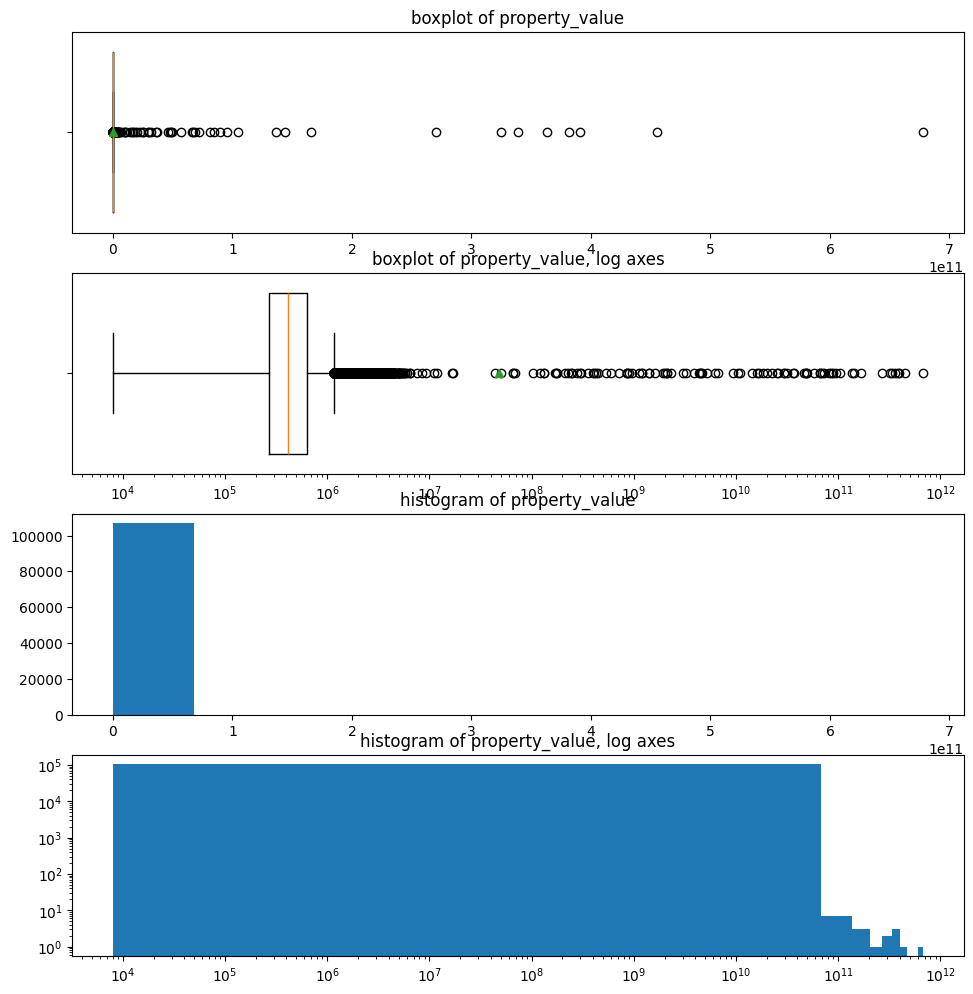

------------------------------------------------------< income >-----------------------------------------------------


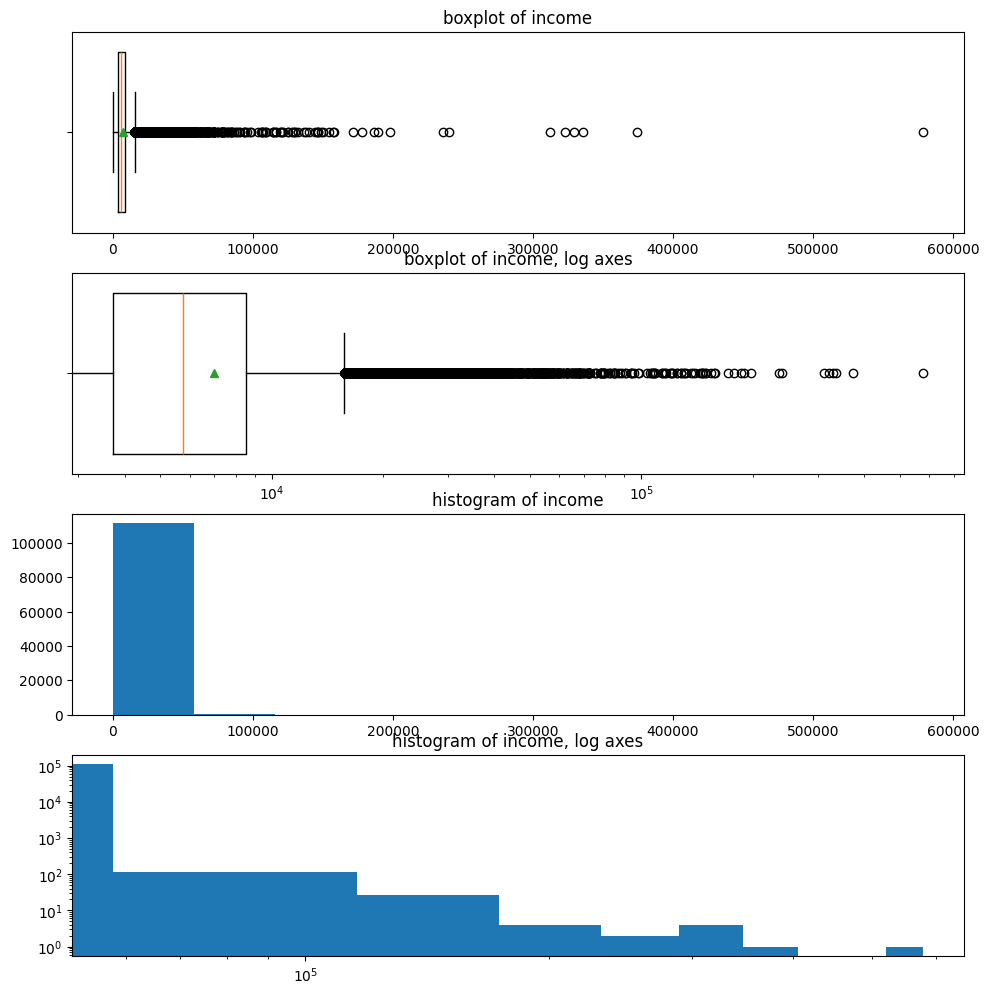

---------------------------------------------------< loan_amount >---------------------------------------------------


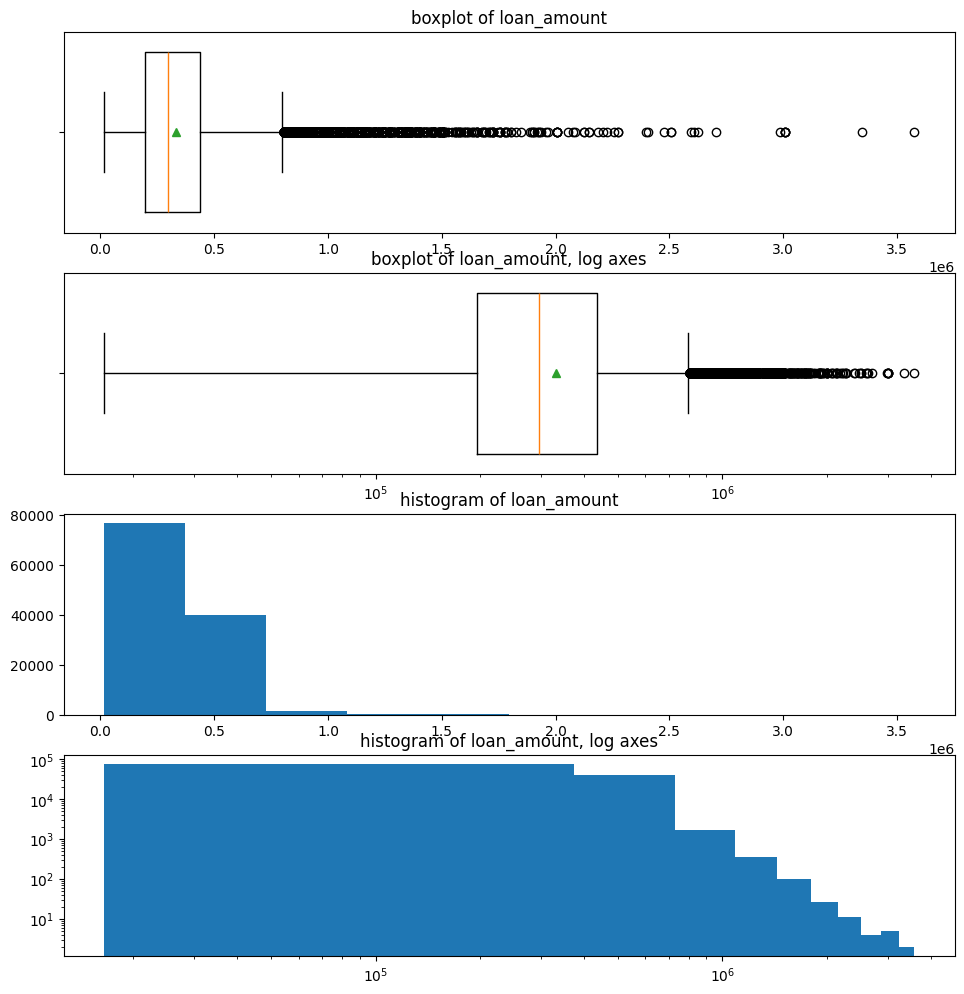

-------------------------------------------------------< ltv >-------------------------------------------------------


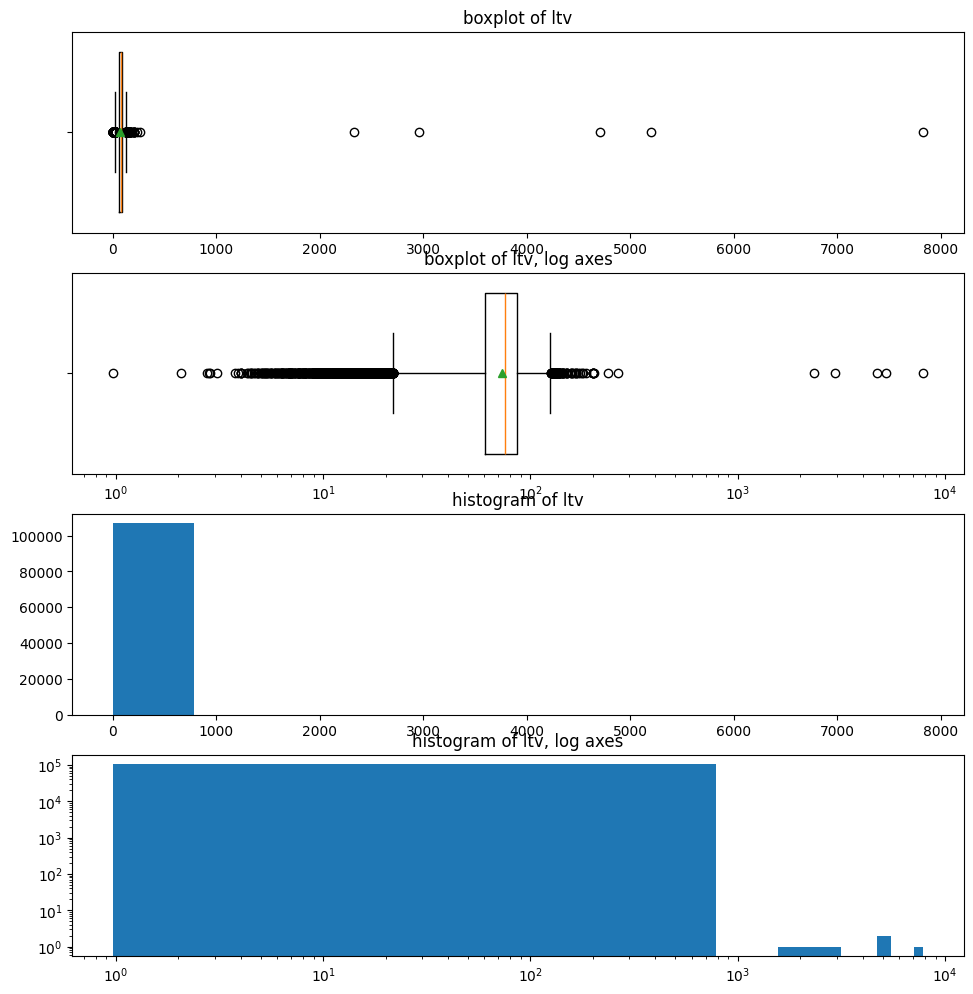

-------------------------------------------------< upfront_charges >-------------------------------------------------


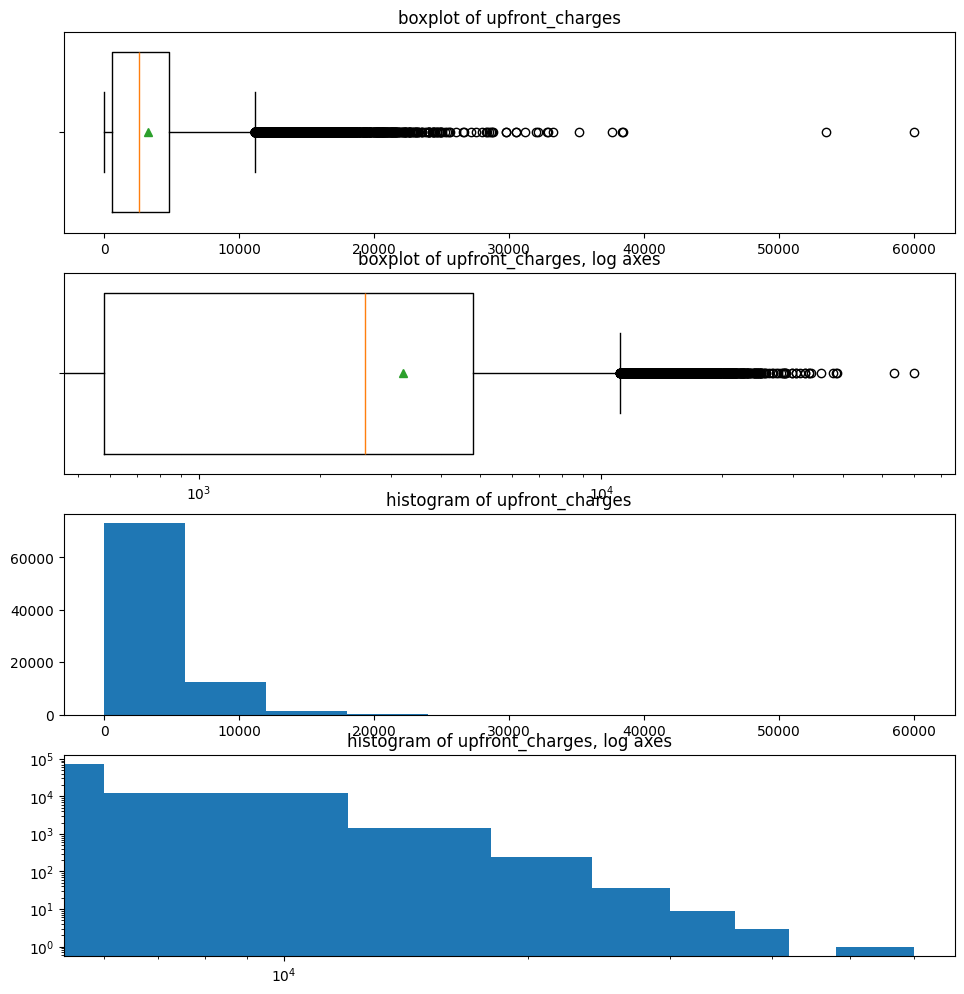

In [25]:
describe_numeric(X=X[['property_value', 'income', 'loan_amount', 'ltv', 'upfront_charges']])

### Missing values detection

Есть ли пропущенные данные?

In [26]:
X.isna().any()

loan_limit                    True
gender                       False
approv_in_adv                 True
loan_type                    False
loan_purpose                  True
credit_worthiness            False
open_credit                  False
business_or_commercial       False
loan_amount                  False
rate_of_interest              True
interest_rate_spread          True
upfront_charges               True
term                          True
neg_ammortization             True
interest_only                False
lump_sum_payment             False
property_value                True
construction_type            False
occupancy_type               False
secured_by                   False
total_units                  False
income                        True
credit_type                  False
credit_score                 False
co-applicant_credit_type     False
age                           True
submission_of_application     True
ltv                           True
region              

---

<div class="alert alert-info">
  <h1><center>Preprocessing (3 балла)</center></h1></div>

# <center>Numerical features</center>

### Deal with extreme values

Напишите / используйте функции / трансформеры, которые будут "исправлять" экстремальные значения (какой способ лучше подходит? почему?)

##### "выбросы" есть, но визуально примерно одинаково присутствуют во всех числовых категориях: 'property_value', 'income', 'loan_amount', 'ltv', 'upfront_charges'

In [27]:
X_numeric = X.select_dtypes(np.number)
X_numeric.head(2)

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,ltv
id,,,,,,,,
89268,216500,3.990,0.8696,1785.38,240.0,308000.0,7380.0,70.292208
125974,606500,3.875,0.2662,3279.06,360.0,758000.0,8580.0,80.013193


In [28]:
X_numeric.isna().any()

loan_amount             False
rate_of_interest         True
interest_rate_spread     True
upfront_charges          True
term                     True
property_value           True
income                   True
ltv                      True
dtype: bool

In [29]:
X_numeric.describe(percentiles=[0.95, 0.99])

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,ltv
count,1.189360e+05,89781.000000,89625.000000,87264.000000,118902.000000,1.068170e+05,111606.000000,106817.000000
mean,3.312533e+05,4.045721,0.441508,3221.204878,335.151225,4.784026e+07,6964.647062,72.740675
std,1.843306e+05,0.560895,0.512811,3247.979387,58.431235,3.795995e+09,6549.553597,38.671953
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,0.967478
50%,2.965000e+05,3.990000,0.390100,2592.060000,360.000000,4.180000e+05,5760.000000,75.135870
95%,6.565000e+05,4.990000,1.378000,9235.425000,360.000000,1.058000e+06,15420.000000,98.728814
99%,8.665000e+05,5.500000,1.611452,14208.316800,360.000000,1.858000e+06,26640.000000,102.852349
max,3.576500e+06,7.750000,2.885400,60000.000000,360.000000,6.779013e+11,578580.000000,7831.250000


In [30]:
class PercentileTransformer(CustomTransformer):
    
    def __init__(self, percentile: float = 0.99) -> None:
        self.percentile = percentile
        self.percentile_values = dict()
        self.feature_names_in_: List[str]
    
    def fit(self, X: pd.DataFrame, y=None, **params):
        self.percentile_values = X.quantile(self.percentile)
        self.feature_names_in_ = list(X.columns)
        return self
    
    def feature_names_out(self, *args, **kwargs): 
        return self.feature_names_in_

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        for column in X.columns:
            if column in self.feature_names_in_:
                X[column] = X[column].where(X[column] <= self.percentile_values[column], self.percentile_values[column])
        return X

In [31]:
#term - OK, не трогать

In [32]:
outliers_transformer = ColumnTransformer(
        transformers = [('percentile_transformer', PercentileTransformer(), 
                        ["loan_amount", 'rate_of_interest', 'interest_rate_spread', 
                         'upfront_charges', 'property_value', 'income', 'ltv'])], 
        verbose_feature_names_out=False, remainder='passthrough'
    )

outliers_transformer.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('percentile_transformer',
                                 PercentileTransformer(),
                                 ['loan_amount', 'rate_of_interest',
                                  'interest_rate_spread', 'upfront_charges',
                                  'property_value', 'income', 'ltv'])],
                  verbose_feature_names_out=False)

### !outliers_transformer самостоятельно заполняет nan - ставить после nan_imputer

### Deal with missing values

Напишите/используйте функции/трансформеры для заполнения пропущенных значений. Какова логика? Напишите краткое пояснение, почему Вы выбрали тот или иной подход

In [33]:
X_numeric.isna().any()

loan_amount             False
rate_of_interest         True
interest_rate_spread     True
upfront_charges          True
term                     True
property_value           True
income                   True
ltv                      True
dtype: bool

In [34]:
X['credit_score'].str.replace('_', '').astype(float).isna().any()

False

In [35]:
'''
loan_amount                  number - int to float - done above - no nan
rate_of_interest             number (24.5% nan) - nan to -1 w sep column (есть 0 в значениях)
interest_rate_spread         number (24.6% nan) - nan to -1 w sep column (есть 0 в значениях)
upfront_charges              number (26.6% nan) - nan to -10 w sep column
term                         number (<1% nan) - nan to most_frequent (мало значений на замену)
property_value               number - nan to 0 w sep column
income                       number (6% nan) - nan to -1 w sep column (есть 0 в значениях)
credit_score                 object - to number (remove "_") - done above - no nan
ltv                          number (10% nan) - nan to 0 w sep column
'''

'\nloan_amount                  number - int to float - done above - no nan\nrate_of_interest             number (24.5% nan) - nan to -1 w sep column (есть 0 в значениях)\ninterest_rate_spread         number (24.6% nan) - nan to -1 w sep column (есть 0 в значениях)\nupfront_charges              number (26.6% nan) - nan to -10 w sep column\nterm                         number (<1% nan) - nan to most_frequent (мало значений на замену)\nproperty_value               number - nan to 0 w sep column\nincome                       number (6% nan) - nan to -1 w sep column (есть 0 в значениях)\ncredit_score                 object - to number (remove "_") - done above - no nan\nltv                          number (10% nan) - nan to 0 w sep column\n'

In [36]:
# замена nan (numeric)
imputer_transformer = ColumnTransformer(
    transformers=[
        (
            "nan_to_-1",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-1, add_indicator = True),
            ['rate_of_interest',  "upfront_charges", 'income', ]
        ), 
        (
            "nan_to_-10",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-10, add_indicator = True),
            ['interest_rate_spread', ]
        ),
        (
            "nan_to_0",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0, add_indicator = True),
            ['property_value', 'ltv', ]
        ),
        (
            "nan_to_mean",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent", add_indicator = True),
            ['term', ]
        )
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

imputer_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('nan_to_-1',
                                 SimpleImputer(add_indicator=True,
                                               fill_value=-1,
                                               strategy='constant'),
                                 ['rate_of_interest', 'upfront_charges',
                                  'income']),
                                ('nan_to_-10',
                                 SimpleImputer(add_indicator=True,
                                               fill_value=-10,
                                               strategy='constant'),
                                 ['interest_rate_spread']),
                                ('nan_to_0',
                                 SimpleImputer(add_indicator=True, fill_value=0,
                                               strategy='constant'),
                                 ['property_value', 'ltv']),
                                ('nan_to_mean',
                                 SimpleImputer(add_indicator=True,
                                               strategy='most_frequent'),
                                 ['term'])],
                  verbose_feature_names_out=False)

---

# <center>Categorical Features</center>

Какие признаки и как Вы будете кодировать?

### Encode nominal featuers

In [37]:
X.select_dtypes("object").columns

Index(['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'credit_worthiness', 'open_credit', 'business_or_commercial',
       'neg_ammortization', 'interest_only', 'lump_sum_payment',
       'construction_type', 'occupancy_type', 'secured_by', 'total_units',
       'credit_type', 'credit_score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'region', 'security_type'],
      dtype='object')

In [38]:
'''
loan_limit                   categ (2 items: cf, ncf) - OHE w nan
gender                       categ (4 items) - OHE
approv_in_adv                categ (2 items: pre, nopre) - OHE w nan
loan_type                    categ (3 items) - OHE
loan_purpose                 categ (4 items) - OHE w nan
credit_worthiness            categ (2 items: l1, l2) - OHE
open_credit                  categ (2 items: opc, nopc) - OHE
business_or_commercial       categ (2 items: b/c, nob/c) - OHE
neg_ammortization            categ (2 items: neg_amm, not_neg) - OHE w nan
interest_only                categ (2 items: int_only, not_int) - OHE
lump_sum_payment             categ (2 items: not_lpsm, lpsm) - OHE
construction_type            categ (2 items: sb, mh) - OHE
occupancy_type               categ (3 items) - OHE
secured_by                   categ (2 items: home, land) - OHE
total_units                  categ (4 items) - OHE
credit_type                  categ (4 items) - OHE
co-applicant_credit_type     categ (2 items: EXP, CIB) - OHE
age                          categ (7 items) - OHE w nan
submission_of_application    categ (2 items: to_inst, not_inst) - OHE
region                       categ (4 items) - OHE
security_type                categ (2 items: direct, Indirect) - OHE
'''

'\nloan_limit                   categ (2 items: cf, ncf) - OHE w nan\ngender                       categ (4 items) - OHE\napprov_in_adv                categ (2 items: pre, nopre) - OHE w nan\nloan_type                    categ (3 items) - OHE\nloan_purpose                 categ (4 items) - OHE w nan\ncredit_worthiness            categ (2 items: l1, l2) - OHE\nopen_credit                  categ (2 items: opc, nopc) - OHE\nbusiness_or_commercial       categ (2 items: b/c, nob/c) - OHE\nneg_ammortization            categ (2 items: neg_amm, not_neg) - OHE w nan\ninterest_only                categ (2 items: int_only, not_int) - OHE\nlump_sum_payment             categ (2 items: not_lpsm, lpsm) - OHE\nconstruction_type            categ (2 items: sb, mh) - OHE\noccupancy_type               categ (3 items) - OHE\nsecured_by                   categ (2 items: home, land) - OHE\ntotal_units                  categ (4 items) - OHE\ncredit_type                  categ (4 items) - OHE\nco-applicant_cre

In [39]:
# categorial encoding
categorical_transformer = ColumnTransformer(
    transformers=[
        (
            "onehot",
            OneHotEncoder(sparse_output=False, drop = 'if_binary', handle_unknown="ignore"),
            ['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
            'credit_worthiness', 'open_credit', 'business_or_commercial',
            'neg_ammortization', 'interest_only', 'lump_sum_payment',
            'construction_type', 'occupancy_type', 'secured_by', 'total_units',
            'credit_type', 'co-applicant_credit_type', 'age',
            'submission_of_application', 'region', 'security_type', ]
        ),
                ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['loan_limit', 'gender', 'approv_in_adv',
                                  'loan_type', 'loan_purpose',
                                  'credit_worthiness', 'open_credit',
                                  'business_or_commercial', 'neg_ammortization',
                                  'interest_only', 'lump_sum_payment',
                                  'construction_type', 'occupancy_type',
                                  'secured_by', 'total_units', 'credit_type',
                                  'co-applicant_credit_type', 'age',
                                  'submission_of_application', 'region',
                                  'security_type'])],
                  verbose_feature_names_out=False)

### Encode ordinal features (если можно проранжировать от худшего к лучшему - таких нет)

In [40]:
# n/a

---

<div class="alert alert-info">
  <h1><center>Pipeline (3 балла)</center></h1></div>

Соберите pipeline, который будет реализовывать все предыдущие трансформации

In [41]:
from sklearn.pipeline import Pipeline

In [42]:
pipe = Pipeline(
                steps = [
                            ('dtype_normalization', dtype_normalization),
                            ('numeric_nans_imputer', imputer_transformer),
                            ('extreme_values_crop', outliers_transformer),
                            ('categorical_transformer', categorical_transformer)
                        ], 
                verbose = True
                )

In [43]:
pipe.set_output(transform = "pandas")

Pipeline(steps=[('dtype_normalization',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('credit_score',
                                                  RegexTransformer(get_first=False,
                                                                   replace={'_': ''},
                                                                   target_dtype=<class 'float'>),
                                                  ['credit_score'])],
                                   verbose_feature_names_out=False)),
                ('numeric_nans_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nan_to_-1',
                                                  SimpleImputer(...
                                                   'approv_in_adv', 'loan_type',
                                                   'loan_purpose',
                                                   'credit_worthiness',
                                                   'open_credit',
                                                   'business_or_commercial',
                                                   'neg_ammortization',
                                                   'interest_only',
                                                   'lump_sum_payment',
                                                   'construction_type',
                                                   'occupancy_type',
                                                   'secured_by', 'total_units',
                                                   'credit_type',
                                                   'co-applicant_credit_type',
                                                   'age',
                                                   'submission_of_application',
                                                   'region',
                                                   'security_type'])],
                                   verbose_feature_names_out=False))],
         verbose=True)

In [44]:
X_train_transformed = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

[Pipeline]  (step 1 of 4) Processing dtype_normalization, total=   0.3s
[Pipeline]  (step 2 of 4) Processing numeric_nans_imputer, total=   0.1s
[Pipeline]  (step 3 of 4) Processing extreme_values_crop, total=   0.1s
[Pipeline]  (step 4 of 4) Processing categorical_transformer, total=   1.1s


In [45]:
X_train_transformed.info()#.columns

<class 'pandas.core.frame.DataFrame'>
Index: 95148 entries, 125974 to 120759
Data columns (total 72 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   loan_limit_cf                          95148 non-null  float64
 1   loan_limit_ncf                         95148 non-null  float64
 2   loan_limit_nan                         95148 non-null  float64
 3   gender_Female                          95148 non-null  float64
 4   gender_Joint                           95148 non-null  float64
 5   gender_Male                            95148 non-null  float64
 6   gender_Sex Not Available               95148 non-null  float64
 7   approv_in_adv_nopre                    95148 non-null  float64
 8   approv_in_adv_pre                      95148 non-null  float64
 9   approv_in_adv_nan                      95148 non-null  float64
 10  loan_type_type1                        95148 non-null  float64
 11  l

In [46]:
#import joblib


#joblib.dump(pipe, "../files/hw3_status_pipeline.pickle")

---

<div class="alert alert-info">
  <h1><center>Model (2 балла)</center></h1></div>

Выберите любую из пройденных моделей и примените её к обработанному датасету

In [47]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [48]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train_transformed, Y_train)

DecisionTreeClassifier(random_state=42)

In [49]:
tree_classifier.tree_.n_leaves

2

In [50]:
tree_classifier.tree_.max_depth

1

In [51]:
tree_classifier.classes_

array([0, 1], dtype=int64)

In [52]:
class_names = ['0', '1']

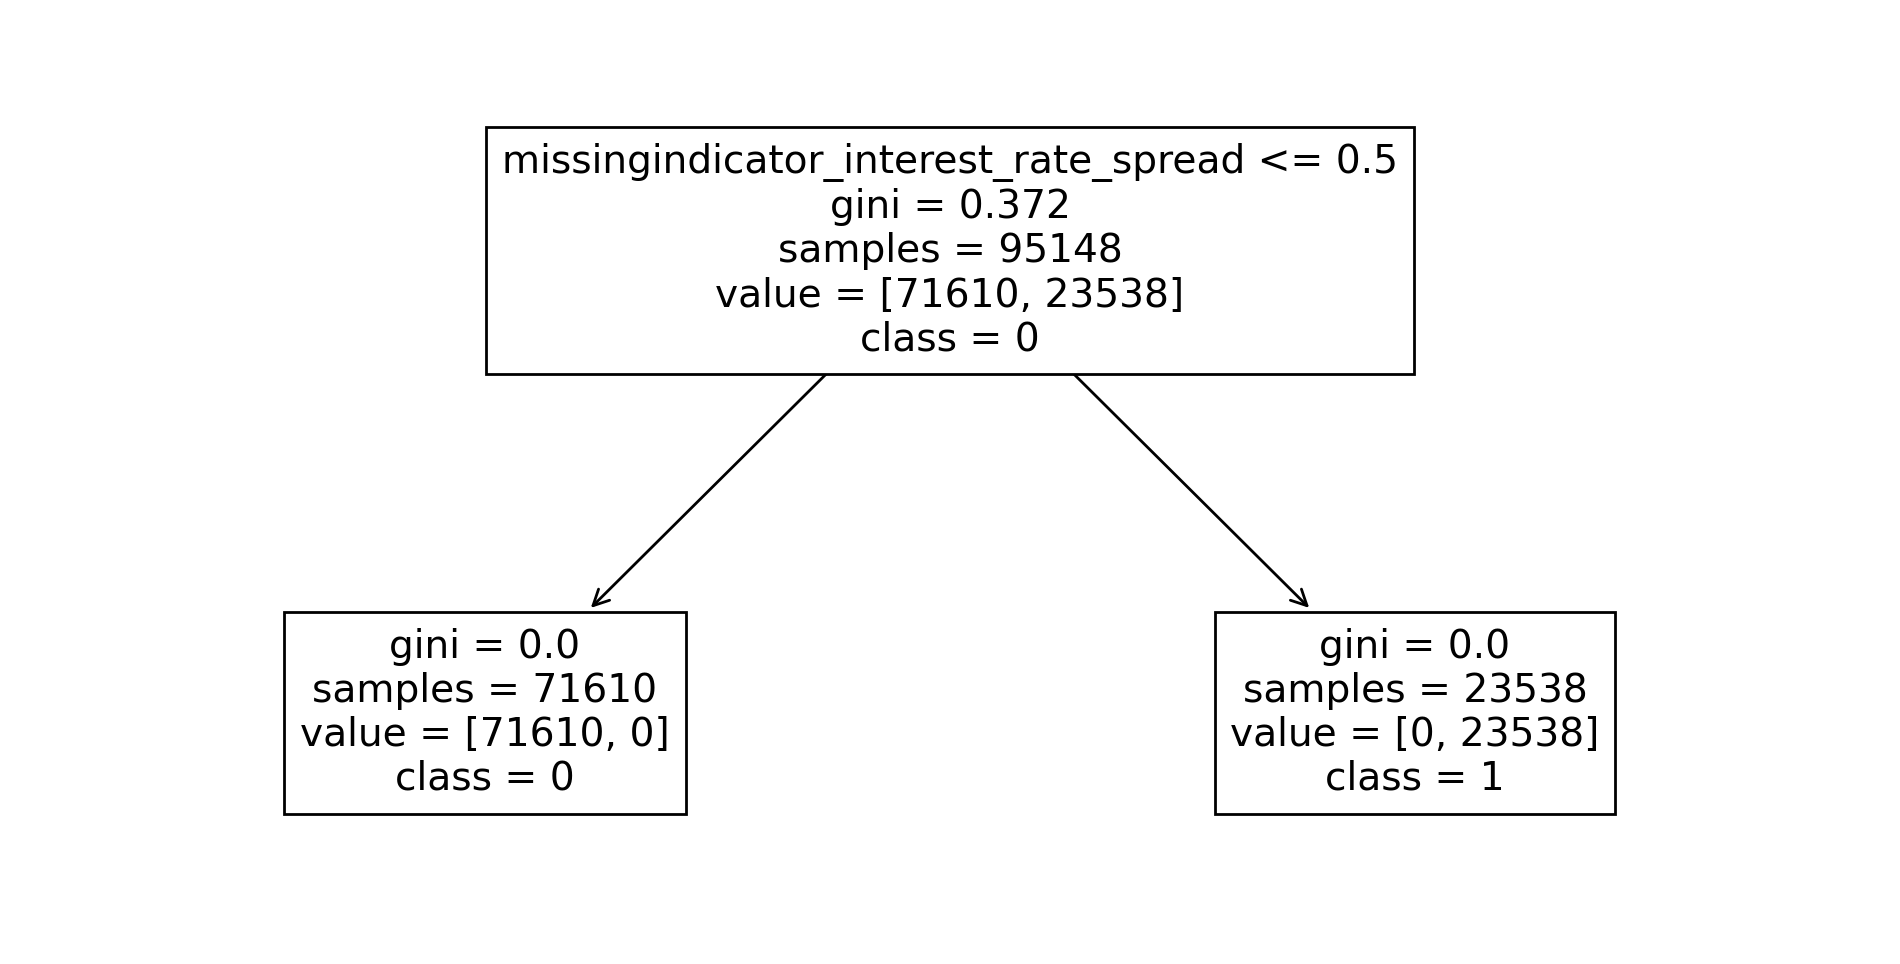

In [53]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
plot_tree(tree_classifier, max_depth=3, feature_names=X_train_transformed.columns, class_names=class_names, rounded=False, ax=ax)
plt.show()

In [54]:
Y_pred_train = tree_classifier.predict(X_train_transformed)
Y_pred_test = tree_classifier.predict(X_test_transformed)
Y_pred_train

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [55]:
Y_pred_test

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

### feature_importances

In [56]:
#X_train_transformed.columns

In [57]:
pd.DataFrame(tree_classifier.feature_importances_).sort_values(by = 0, ascending = False).head(3)

,0
66,1.0
0,0.0
45,0.0


In [58]:
pd.DataFrame(X_train_transformed.columns).iloc[66,:]

0    missingindicator_interest_rate_spread
Name: 66, dtype: object

## Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from functools import partial

In [60]:
confusion_matrix(Y_train, Y_pred_train)

array([[71610,     0],
       [    0, 23538]], dtype=int64)

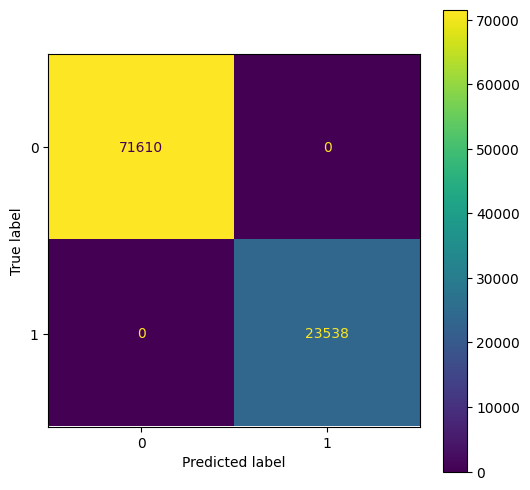

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(Y_train, Y_pred_train, ax=ax)
ax.grid(False)
plt.show()

In [62]:
def compare_train_test_confusion_matrix(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4))
    cm = partial(ConfusionMatrixDisplay.from_estimator, estimator=model, colorbar=False, values_format=",.3f", normalize="pred")
    cm(X=X_train, y=Y_train, ax=ax1)
    cm(X=X_test, y=Y_test, ax=ax2)
    ax1.set_title("Train")
    ax2.set_title("Test")
    ax1.grid(False)
    ax2.grid(False)
    plt.suptitle("Classifier performace on Seen and Unseed data")
    plt.show()

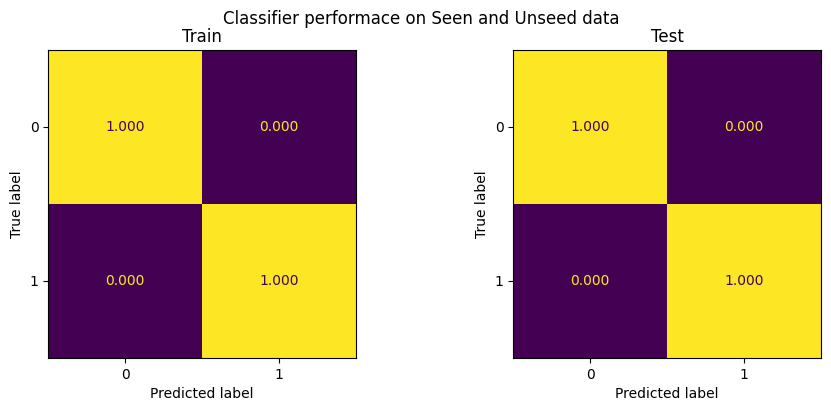

In [63]:
compare_train_test_confusion_matrix(tree_classifier, X_train_transformed, Y_train, X_test_transformed, Y_test)

## <font color = red> Очень сильное (100%) влияние "interest_rate_spread" (а также rate_of_interest и upfront_charges (т.к. взаимосвязаны)  - удалить<font>

In [64]:
X_train_transformed_upd = X_train_transformed.drop(
    columns = ['missingindicator_interest_rate_spread', 
               'interest_rate_spread', 
               'missingindicator_rate_of_interest',
               'rate_of_interest',
               'missingindicator_upfront_charges',
               'upfront_charges'])
X_test_transformed_upd = X_test_transformed.drop(
    columns = ['missingindicator_interest_rate_spread', 
               'interest_rate_spread', 
               'missingindicator_rate_of_interest',
               'rate_of_interest',
               'missingindicator_upfront_charges',
               'upfront_charges'])

In [65]:
#X_train_transformed_upd.columns

In [66]:
upd_tree_classifier = DecisionTreeClassifier(random_state=42)
upd_tree_classifier.fit(X_train_transformed_upd, Y_train)

DecisionTreeClassifier(random_state=42)

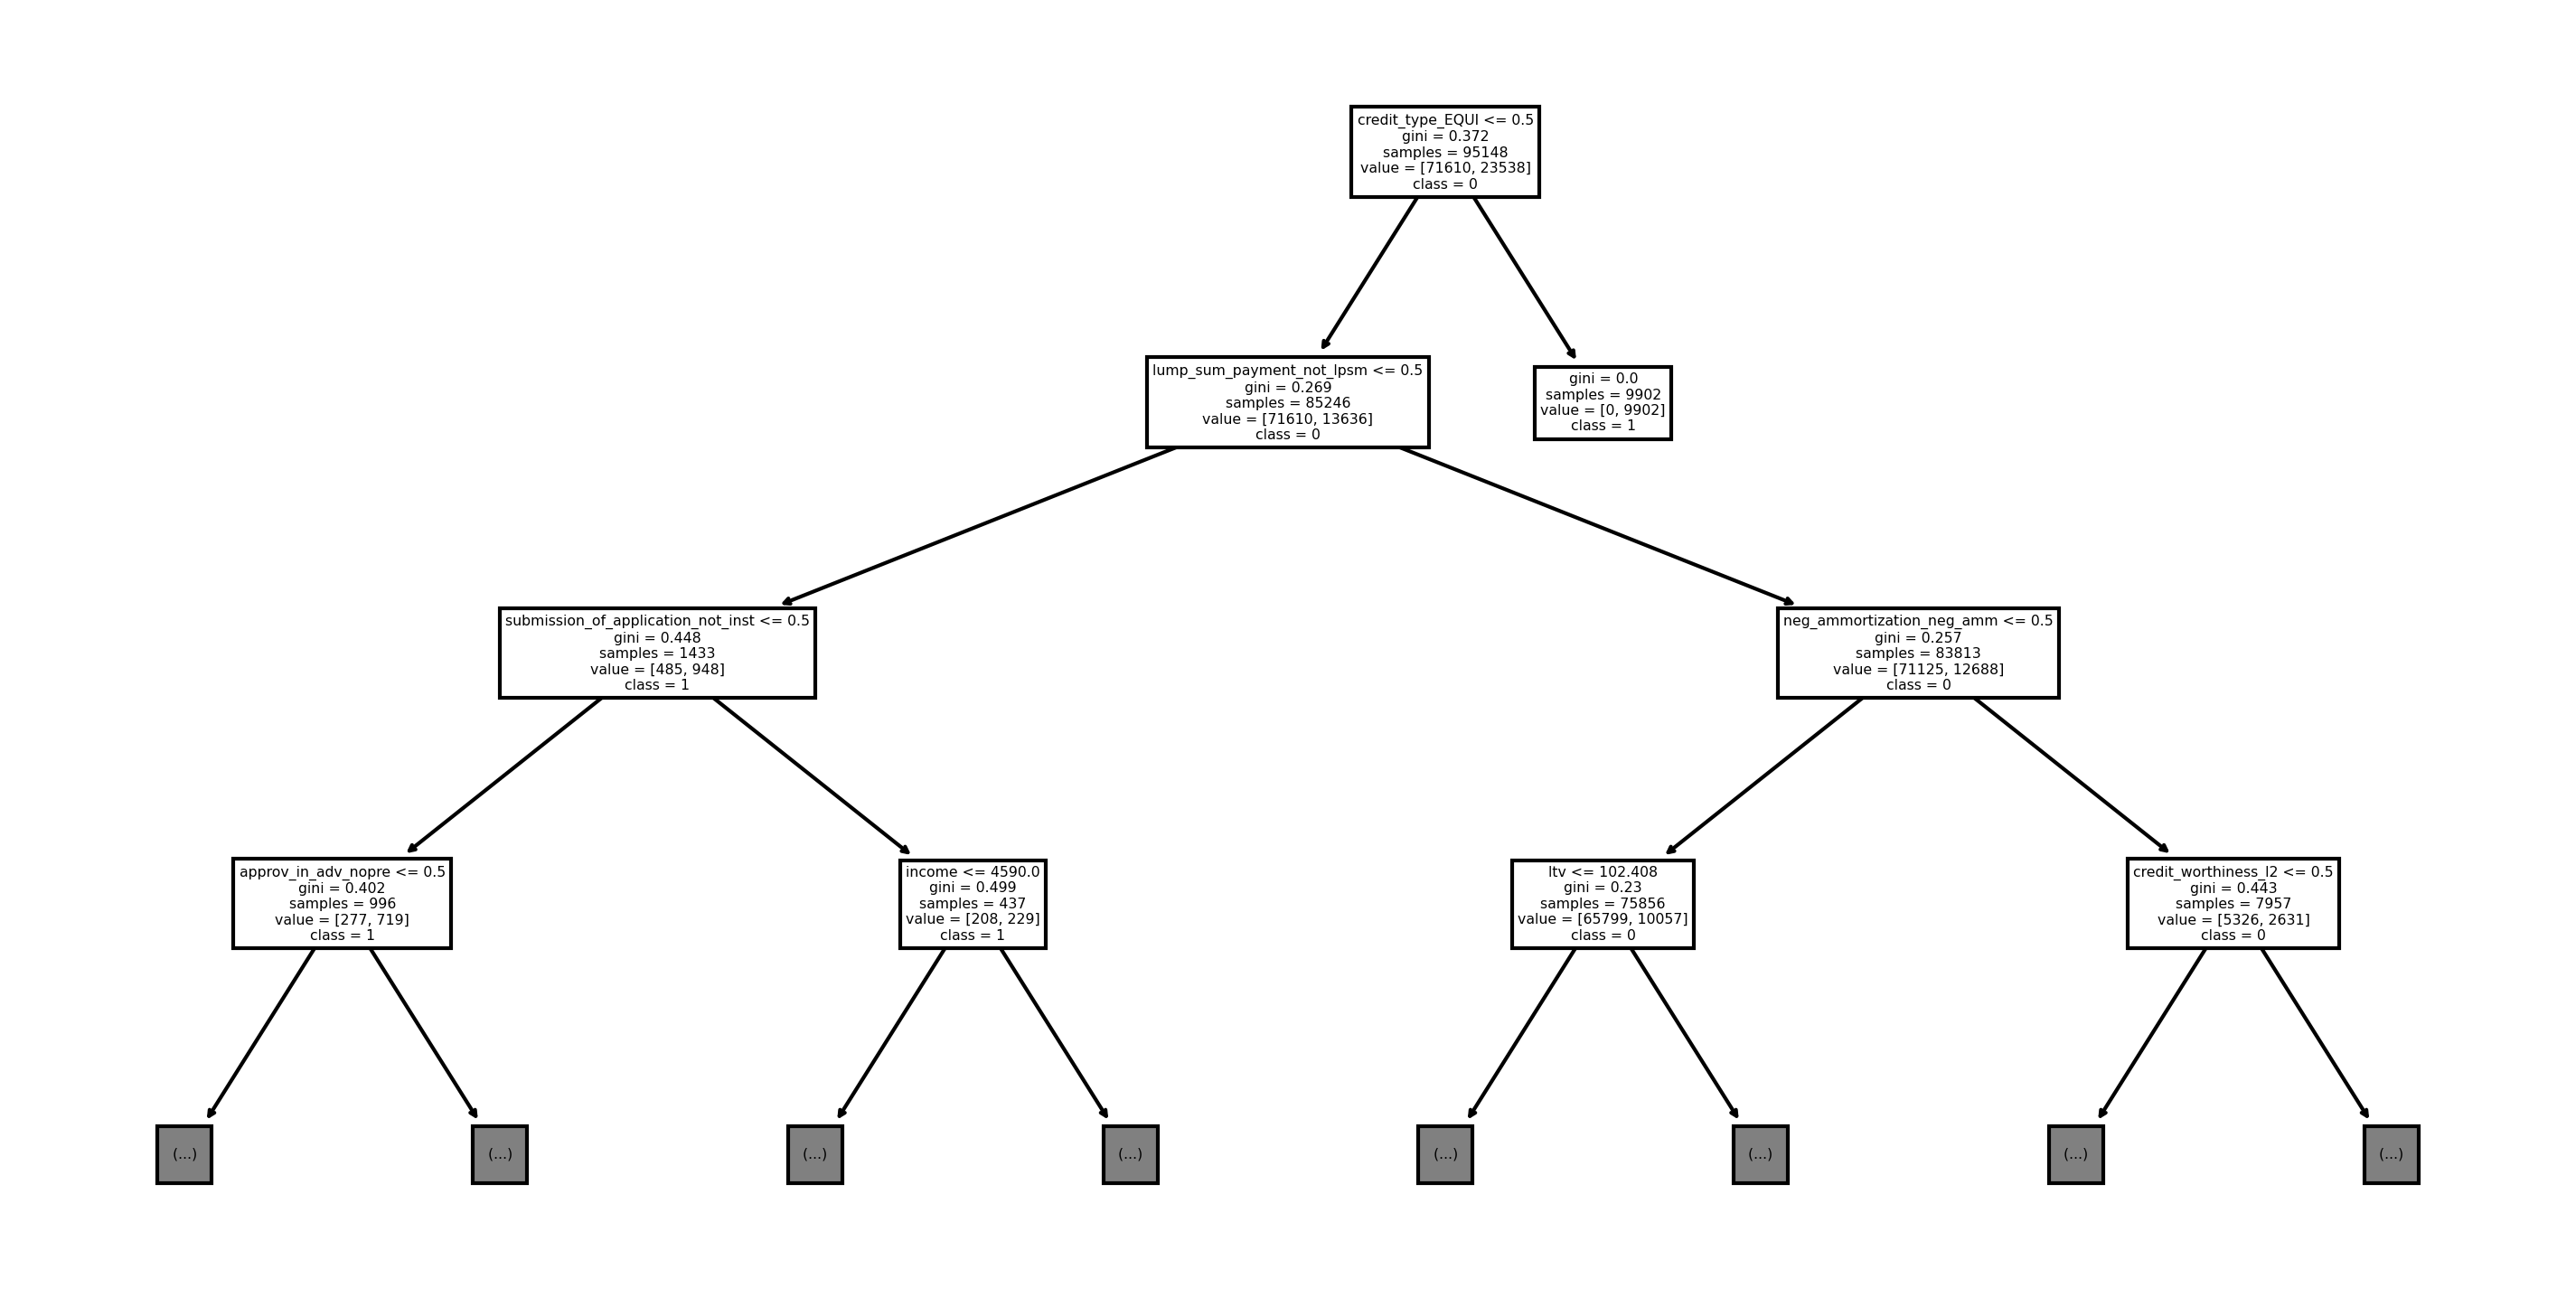

In [67]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
plot_tree(upd_tree_classifier, max_depth=3, feature_names=X_train_transformed_upd.columns, class_names=class_names, rounded=False, ax=ax)
plt.show()

In [68]:
Y_pred_train_upd = upd_tree_classifier.predict(X_train_transformed_upd)
Y_pred_test_upd = upd_tree_classifier.predict(X_test_transformed_upd)

In [69]:
pd.DataFrame(upd_tree_classifier.feature_importances_).sort_values(by = 0, ascending = False)

,0
37,0.353389
59,0.097444
65,0.088269
58,0.087157
56,0.052399
...,...
47,0.000000
61,0.000000
62,0.000000
30,0.000000


In [70]:
pd.DataFrame(X_train_transformed_upd.columns).iloc[37,:]

0    credit_type_EQUI
Name: 37, dtype: object

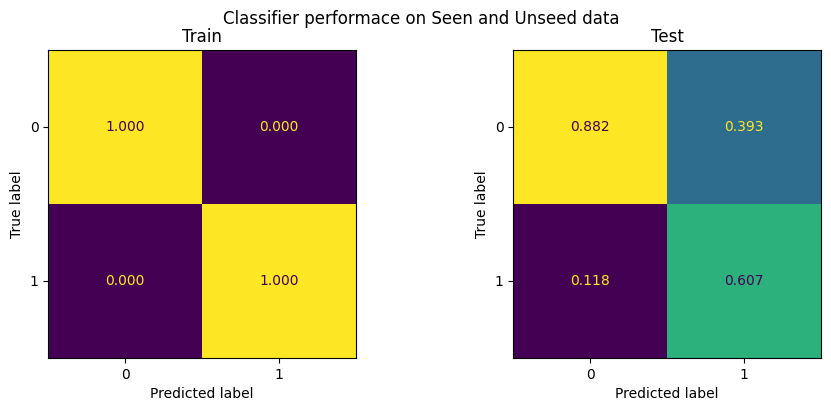

In [71]:
compare_train_test_confusion_matrix(upd_tree_classifier, X_train_transformed_upd, Y_train, X_test_transformed_upd, Y_test)

In [72]:
upd_tree_classifier.tree_.n_leaves

12062

In [73]:
upd_tree_classifier.tree_.max_depth

45

## <font color = red> Всё ещё очень сильно переучивается - ограничим модель<font>

## Restricted Tree classifier

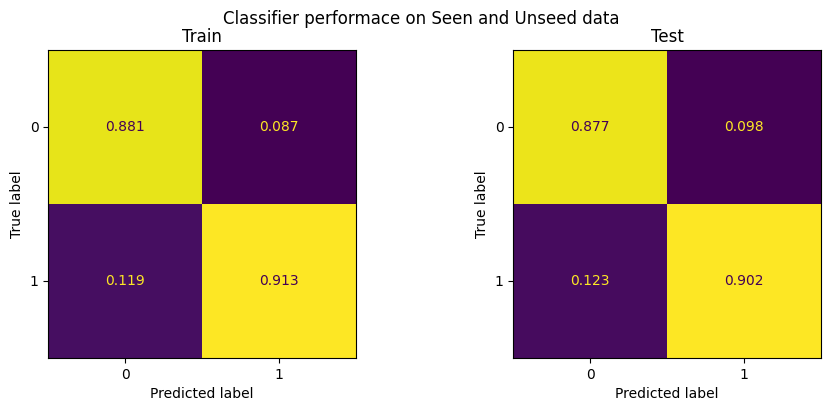

In [74]:
restricted_classifier = DecisionTreeClassifier(random_state=42, max_depth=20, min_samples_leaf=50)
compare_train_test_confusion_matrix(restricted_classifier, X_train_transformed_upd, Y_train, X_test_transformed_upd, Y_test)

In [75]:
Y_pred_train_restricted = restricted_classifier.predict(X_train_transformed_upd)
Y_pred_test_restricted = restricted_classifier.predict(X_test_transformed_upd)

In [76]:
pd.DataFrame(restricted_classifier.feature_importances_).sort_values(by = 0, ascending = False).head(3)

,0
37,0.662660
59,0.059175
58,0.049516


In [77]:
pd.DataFrame(X_train_transformed_upd.columns).iloc[37,:]

0    credit_type_EQUI
Name: 37, dtype: object

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [79]:
def compare_train_test_metrics(metric_func, y_train, pred_train, y_test, pred_test):
    print(f"Train score: {metric_func(Y_train, pred_train):,.3f}")
    print(f"Test score: {metric_func(Y_test, pred_test):,.3f}")

In [80]:
compare_train_test_metrics(accuracy_score, Y_train, Y_pred_train_restricted, Y_test, Y_pred_test_restricted)

Train score: 0.886
Test score: 0.881


In [81]:
compare_train_test_metrics(precision_score, Y_train, Y_pred_train_restricted, Y_test, Y_pred_test_restricted)

Train score: 0.913
Test score: 0.902


In [82]:
compare_train_test_metrics(recall_score, Y_train, Y_pred_train_restricted, Y_test, Y_pred_test_restricted)

Train score: 0.596
Test score: 0.571


In [83]:
compare_train_test_metrics(f1_score, Y_train, Y_pred_train_restricted, Y_test, Y_pred_test_restricted)

Train score: 0.721
Test score: 0.699


<div class="alert alert-info">
  <h1><center>Benchmark</center></h1></div>

In [84]:
from sklearn.metrics import classification_report

In [85]:
benchmark_classifier = DecisionTreeClassifier(random_state=42)
benchmark_classifier.fit(X_train_transformed_upd, Y_train)
Y_pred_benchmark = benchmark_classifier.predict(X_test_transformed_upd)
print(classification_report(Y_test, Y_pred_benchmark))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     18015
           1       0.61      0.64      0.62      5773

    accuracy                           0.81     23788
   macro avg       0.74      0.75      0.75     23788
weighted avg       0.82      0.81      0.81     23788



In [86]:
# При ограничении модели
benchmark_classifier = DecisionTreeClassifier(random_state=42, max_depth=20, min_samples_leaf=50)
benchmark_classifier.fit(X_train_transformed_upd, Y_train)
Y_pred_benchmark = benchmark_classifier.predict(X_test_transformed_upd)
print(classification_report(Y_test, Y_pred_benchmark))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     18015
           1       0.90      0.57      0.70      5773

    accuracy                           0.88     23788
   macro avg       0.89      0.78      0.81     23788
weighted avg       0.88      0.88      0.87     23788



<div class="alert alert-info">
  <h1><center>Voting Classifier</center></h1></div>

In [87]:
from sklearn.ensemble import VotingClassifier

In [88]:
voting_classifier = VotingClassifier(
    estimators=[
                (f"dt_{i}", DecisionTreeClassifier(max_depth=20, max_features=25))
                for i in range(20)
            ],
    n_jobs=-1,
    voting="hard",
).set_output(transform="pandas")

voting_classifier.fit(X_train_transformed_upd, Y_train)

VotingClassifier(estimators=[('dt_0',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_1',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_2',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_3',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_4',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_5',
                              Dec...
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_15',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_16',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_17',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_18',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25)),
                             ('dt_19',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features=25))],
                 n_jobs=-1)

### Hard Voting

In [89]:
Y_pred_hard_voting = voting_classifier.predict(X_test_transformed_upd)

In [90]:
print(" Benchmark ".center(53, "-"))
print(classification_report(Y_test, Y_pred_benchmark))
print(" Hard Voting ".center(53, "-"))
print(classification_report(Y_test, Y_pred_hard_voting))

--------------------- Benchmark ---------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     18015
           1       0.90      0.57      0.70      5773

    accuracy                           0.88     23788
   macro avg       0.89      0.78      0.81     23788
weighted avg       0.88      0.88      0.87     23788

-------------------- Hard Voting --------------------
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     18015
           1       0.93      0.56      0.70      5773

    accuracy                           0.88     23788
   macro avg       0.90      0.77      0.81     23788
weighted avg       0.89      0.88      0.87     23788



### Soft Voting

In [91]:
voting_classifier = VotingClassifier(
    estimators=[
                (f"dt_{i}", DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, max_features=30))
                for i in range(20)
            ],
    n_jobs=-1,
    voting="soft",
).set_output(transform="pandas")

voting_classifier.fit(X_train_transformed_upd, Y_train)

VotingClassifier(estimators=[('dt_0',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=30,
                                                     min_samples_leaf=50)),
                             ('dt_1',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=30,
                                                     min_samples_leaf=50)),
                             ('dt_2',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=30,
                                                     min_samples_leaf=50)),
                             ('dt_3',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=30,
                                                     min_samples_leaf=50...
                             ('dt_16',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=30,
                                                     min_samples_leaf=50)),
                             ('dt_17',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=30,
                                                     min_samples_leaf=50)),
                             ('dt_18',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=30,
                                                     min_samples_leaf=50)),
                             ('dt_19',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=30,
                                                     min_samples_leaf=50))],
                 n_jobs=-1, voting='soft')

In [92]:
Y_pred_soft_voting = voting_classifier.predict(X_test_transformed_upd)

In [93]:
print(" Benchmark ".center(53, "-"))
print(classification_report(Y_test, Y_pred_benchmark))
print(" Hard Voting ".center(53, "-"))
print(classification_report(Y_test, Y_pred_hard_voting))
print(" Soft Voting ".center(53, "-"))
print(classification_report(Y_test, Y_pred_soft_voting))

--------------------- Benchmark ---------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     18015
           1       0.90      0.57      0.70      5773

    accuracy                           0.88     23788
   macro avg       0.89      0.78      0.81     23788
weighted avg       0.88      0.88      0.87     23788

-------------------- Hard Voting --------------------
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     18015
           1       0.93      0.56      0.70      5773

    accuracy                           0.88     23788
   macro avg       0.90      0.77      0.81     23788
weighted avg       0.89      0.88      0.87     23788

-------------------- Soft Voting --------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     18015
           1       0.97      0.49      0.65      5773

    accuracy        

<div class="alert alert-info">
  <h1><center>Random Forest</center></h1></div>

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
rfc = RandomForestClassifier(criterion = 'gini', n_estimators=250, max_depth=15, max_features='sqrt', n_jobs=-1, random_state=42)
rfc.fit(X_train_transformed_upd, Y_train)
Y_pred_decision_tree = rfc.predict(X_test_transformed_upd)

In [96]:
pd.DataFrame(rfc.feature_importances_).sort_values(by = 0, ascending = False).head(5)

,0
59,0.203203
37,0.150780
61,0.119817
57,0.116824
62,0.112187


In [97]:
pd.DataFrame(X_train_transformed_upd.columns).iloc[59,:]

0    ltv
Name: 59, dtype: object

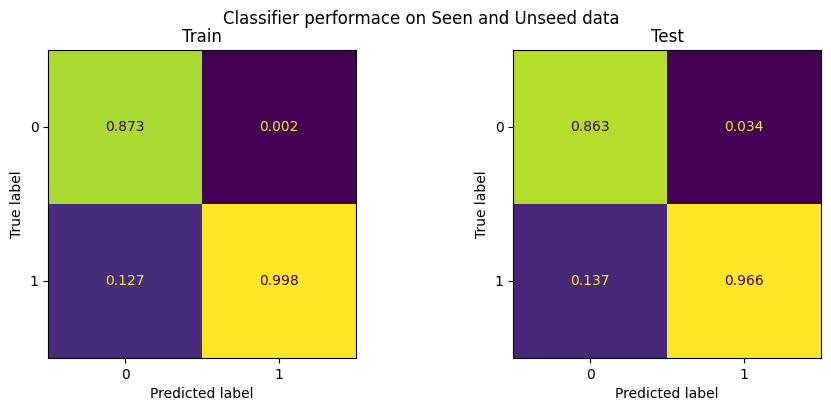

In [98]:
compare_train_test_confusion_matrix(rfc, X_train_transformed_upd, Y_train, X_test_transformed_upd, Y_test)

In [99]:
print(" Benchmark ".center(53, "-"))
print(classification_report(Y_test, Y_pred_benchmark))
print(" Soft Voting ".center(53, "-"))
print(classification_report(Y_test, Y_pred_soft_voting))
print(" Random Forest ".center(53, "-"))
print(classification_report(Y_test, Y_pred_decision_tree))

--------------------- Benchmark ---------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     18015
           1       0.90      0.57      0.70      5773

    accuracy                           0.88     23788
   macro avg       0.89      0.78      0.81     23788
weighted avg       0.88      0.88      0.87     23788

-------------------- Soft Voting --------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     18015
           1       0.97      0.49      0.65      5773

    accuracy                           0.87     23788
   macro avg       0.91      0.74      0.79     23788
weighted avg       0.89      0.87      0.86     23788

------------------- Random Forest -------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     18015
           1       0.97      0.51      0.66      5773

    accuracy        

---